In [1]:
# !pip install --no-cache-dir transformers huggingface_hub torchaudio soundfile --quiet

In [2]:
# !pip install --quiet git+https://github.com/speechbrain/speechbrain.git@develop

# Imports

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/')

import pandas as pd
import re
import numpy as np

# Select sample

In [4]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')
ind = 0
script = df['transcript'][ind]
audio_path = df['path'][ind]
script_cleaned = re.sub(r'\s+', ' ', script).strip()
print(script_cleaned)

Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.


# Read in sample data and convert

In [5]:
import torchaudio

# Load the MP3 file
signal, sr = torchaudio.load(audio_path)

# Resample to 16kHz if needed
if sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    signal = resampler(signal)

# Save as temporary WAV for classification
torchaudio.save("temp.wav", signal, 16000)

# Predict accent

In [6]:
from speechbrain.inference import EncoderClassifier

# Load the ECAPA-TDNN based accent classifier
classifier = EncoderClassifier.from_hparams(
    source="Jzuluaga/accent-id-commonaccent_ecapa",
    savedir="pretrained_models/accent-id-ecapa"
)

# Classify the audio
out_prob, score, index, text_lab = classifier.classify_file("temp.wav")

# Print results
print(f"Predicted Accent: {text_lab[0]}")

/opt/anaconda3/lib/python3.12/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
CategoricalEncoder.expect_len was never called: assuming category count of 16 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.


Predicted Accent: us


# Classify all samples with pretrained model from speechbrain

In [7]:
accents_model = []

for ind in range(len(df)):
  script = df['transcript'][ind]
  audio_path = df['path'][ind]

  # Load the MP3 file
  signal, sr = torchaudio.load(audio_path)

  # Resample to 16kHz if needed
  if sr != 16000:
      resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
      signal = resampler(signal)

  # Save as temporary WAV for classification
  torchaudio.save("temp.wav", signal, 16000)

  # Load the ECAPA-TDNN based accent classifier
  classifier = EncoderClassifier.from_hparams(
      source="Jzuluaga/accent-id-commonaccent_ecapa",
      savedir="pretrained_models/accent-id-ecapa"
  )

  # Classify the audio
  out_prob, score, index, text_lab = classifier.classify_file("temp.wav")

  # Save results
  accents_model.append(text_lab[0])
  print(f"{ind}/{len(df)}: {text_lab[0]}")

0/661: us
1/661: england
2/661: australia
3/661: us
4/661: us
5/661: us
6/661: us
7/661: australia
8/661: us
9/661: us
10/661: england
11/661: england
12/661: england
13/661: england
14/661: us
15/661: us
16/661: us
17/661: us
18/661: us
19/661: us
20/661: us
21/661: us
22/661: us
23/661: england
24/661: us
25/661: us
26/661: us
27/661: us
28/661: us
29/661: us
30/661: singapore
31/661: us
32/661: us
33/661: canada
34/661: us
35/661: us
36/661: indian
37/661: australia
38/661: us
39/661: england
40/661: australia
41/661: england
42/661: us
43/661: us
44/661: us
45/661: us
46/661: us
47/661: england
48/661: us
49/661: us
50/661: us
51/661: us
52/661: us
53/661: us
54/661: us
55/661: scotland
56/661: england
57/661: england
58/661: us
59/661: us
60/661: us
61/661: us
62/661: us
63/661: us
64/661: us
65/661: us
66/661: us
67/661: us
68/661: australia
69/661: us
70/661: us
71/661: scotland
72/661: australia
73/661: us
74/661: us
75/661: us
76/661: australia
77/661: us
78/661: us
79/661: sc

In [18]:
countries = np.array(df['country'])
scripts = np.array(df['transcript'])
audio_paths = np.array(df['path'])

mask = np.array([len(countries[ind].split(',')) == 1 for ind in range(len(countries))], dtype=bool)
countries, scripts, audio_paths = countries[mask], scripts[mask], audio_paths[mask]
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'

accents_model_sample = np.array(accents_model)[mask]
accents_model_sample = accents_model_sample.astype(object)
accents_model_sample[accents_model_sample == 'us'] = 'usa'
accents_model_sample[accents_model_sample == 'england'] = 'uk'
accents_model_sample[accents_model_sample == 'newzealand'] = 'new zealand'

print(f"accuracy: {np.sum(accents_model_sample == countries)/len(countries)}")

accuracy: 0.7798319327731092


In [9]:
country_label = 'scotland'
ind = countries == country_label
np.sum(accents_model_sample[ind] == country_label)/np.sum(ind)

0.0

In [10]:
countries

array(['usa', 'uk', 'australia', 'usa', 'usa', 'usa', 'usa', 'usa', 'uk',
       'uk', 'uk', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'canada', 'canada', 'canada', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'uk', 'usa', 'uk',
       'new zealand', 'south africa', 'canada', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'northern ireland', 'usa', 'usa', 'canada', 'usa', 'usa', 'canada',
       'usa', 'usa', 'usa', 'usa', 'australia', 'usa', 'usa', 'ireland',
       'australia', 'usa', 'usa', 'usa', 'australia', 'usa', 'usa', 'usa',
       'usa', 'usa', 'australia', 'uk', 'usa', 'australia', 'usa', 'usa',
       'usa', 'jamaica', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'canada', 'usa', 'usa', 'usa', 'canada', 'usa',
       'usa', 'uk', 'usa', 'uk', 'us virgin islands', 'usa', 'uk', 'usa',
       'usa', 'usa', 'canada', 'canada', 'usa', 'usa', 'australia', 'usa',
    

In [11]:
accents_model_sample

array(['usa', 'uk', 'australia', 'usa', 'usa', 'usa', 'usa', 'usa', 'uk',
       'uk', 'uk', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'canada', 'usa', 'usa', 'indian', 'australia', 'usa', 'uk',
       'australia', 'uk', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'scotland', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'australia', 'usa',
       'usa', 'scotland', 'australia', 'usa', 'usa', 'usa', 'australia',
       'usa', 'usa', 'usa', 'usa', 'usa', 'australia', 'usa', 'usa',
       'australia', 'usa', 'usa', 'usa', 'canada', 'canada', 'usa', 'usa',
       'usa', 'usa', 'canada', 'usa', 'usa', 'usa', 'usa', 'usa',
       'canada', 'canada', 'usa', 'usa', 'usa', 'usa', 'usa', 'uk', 'usa',
       'usa', 'uk', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'uk',
       'usa', 'usa', 'canada', 'uk', 'usa', 'usa', 'usa', 'sco

# Basic classfier

In [12]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')
countries = np.array(df['country'])
scripts = np.array(df['transcript'])
audio_paths = np.array(df['path'])

mask = np.array([len(countries[ind].split(',')) == 1 for ind in range(len(countries))], dtype=bool) # remove samples from multiple countries
countries, scripts, audio_paths = countries[mask], scripts[mask], audio_paths[mask]
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'
counts = df['country'].value_counts()

df_data = pd.DataFrame({'path': audio_paths, 'script': scripts, 'country': countries})
df_data['country'] = df_data['country'].apply(lambda x: x if counts[x] >= 2 else 'Other') # classifies accents with <2 samples as "Other"
df_data

,path,script,country
0,SpeechAccentArchive/english1.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa
1,SpeechAccentArchive/english2.mp3,\r\nPlease call Stella. Ask her to bring thes...,uk
2,SpeechAccentArchive/english3.mp3,\r\nPlease call Stella. Ask her to bring thes...,australia
3,SpeechAccentArchive/english5.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa
4,SpeechAccentArchive/english6.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa
...,...,...,...
590,SpeechAccentArchive/english657.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa
591,SpeechAccentArchive/english658.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa
592,SpeechAccentArchive/english659.mp3,\r\nPlease call Stella. Ask her to bring thes...,australia
593,SpeechAccentArchive/english660.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torchaudio

max_duration = 30
sample_rate = 16000
class AccentDataset:
    def __init__(self, df, sample_rate=sample_rate, max_duration=max_duration):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = sample_rate * max_duration  # e.g., 5 seconds
        self.label_encoder = LabelEncoder()
        self.df['country'] = self.label_encoder.fit_transform(df['country'])
        self.country_id = dict(enumerate(self.label_encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        label = row['country']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        return torch.tensor(wav, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [14]:
import torch.nn as nn
from torch.utils.data import random_split
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

# Split data into training and validation
num_train = int(0.8 * len(df_data))
num_val = len(df_data) - num_train

train_df, val_df = train_test_split(
    df_data,
    test_size=0.2,
    stratify=df_data['country'],  # ensures all classes are represented
    random_state=42
)
train_ds = AccentDataset(train_df)
val_ds = AccentDataset(val_df)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Set up model
features = 2**6 # runs out of RAM >2**10
data_dim = sample_rate*max_duration
num_countries = len(set(df_data['country']))

simple_net = nn.Sequential(
            nn.Linear(data_dim, features),
            nn.ReLU(),
            nn.Linear(features, num_countries)
        )

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=accuracy) # CrossEntropyLoss for single-label classification according to FastAI chapter 6
learn.fit(5) # argument in parentheses is number of epochs

epoch,train_loss,valid_loss,accuracy,time
0,2.293439,2.287010,0.008403,00:07
1,2.269032,2.271996,0.008403,00:07
2,2.244036,2.257221,0.016807,00:07
3,2.218012,2.242633,0.142857,00:07
4,2.191606,2.228176,0.529412,00:07


/var/folders/17/sm6fmj1n6b59p4ytl1qvtdvw0000gn/T/ipykernel_71675/2438335830.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Text(0.5, 1.0, 'Final accuracy: 0.529411792755127')

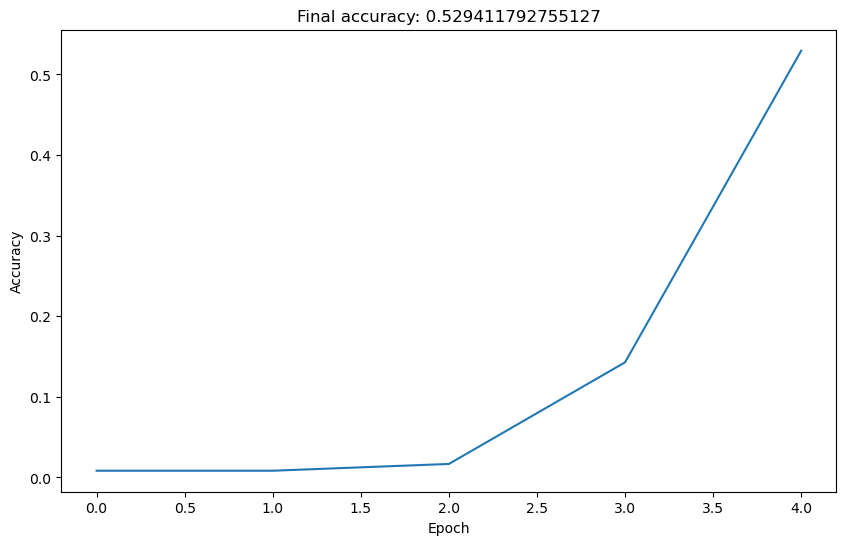

In [15]:

plt.figure(figsize=(10,6))
plt.plot(L(learn.recorder.values).itemgot(2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Final accuracy: {learn.recorder.values[-1][2]}")

In [16]:
preds, _ = learn.get_preds(dl=val_dl)
pred_classes = preds.argmax(dim=1)

/var/folders/17/sm6fmj1n6b59p4ytl1qvtdvw0000gn/T/ipykernel_71675/2438335830.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [17]:
[print(int(pred_classes[i]), list(val_ds.df['country'])[i]) for i in range(len(pred_classes))];

9 9
9 9
9 9
9 9
9 2
9 1
9 9
9 9
9 9
9 5
7 9
7 9
9 9
7 9
9 9
9 8
9 9
7 9
9 0
9 9
9 9
9 8
9 9
9 3
9 6
9 1
7 9
9 9
9 9
9 9
7 9
7 8
9 9
7 9
9 9
7 9
9 9
9 3
9 9
9 9
9 9
7 9
7 9
9 9
7 9
9 9
7 9
7 9
9 2
9 4
9 9
7 9
9 9
9 8
9 9
7 9
9 9
9 9
7 9
9 9
9 0
9 9
9 2
9 1
9 9
9 9
7 9
9 1
9 9
7 9
9 9
9 9
9 9
9 8
7 2
7 9
9 9
7 1
7 2
9 9
9 9
9 9
9 9
7 9
9 9
7 9
9 9
9 9
9 8
9 9
9 8
9 9
9 9
7 9
9 9
9 9
9 1
9 9
9 1
9 9
9 9
9 9
9 9
9 9
9 9
9 9
9 9
9 9
9 2
7 8
7 9
7 2
9 9
9 7
7 9
9 9
9 9
9 8
9 2
